## **1. Import Statements**

In [ ]:
import pandas as pd
import numpy as np
# visualisations
import matplotlib.pyplot as plt
import seaborn as sns
# outlier detection
from scipy.stats import zscore, randint, uniform
# model building
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import joblib
# model accuracy
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# anova
import statsmodels.api as sm
from statsmodels.formula.api import ols

## **2. Reading and Cleaning Data**

### **2.1 Reading and Exploring Data**

In [51]:
file_path = 'insurance.csv'
df_insurance = pd.read_csv(file_path)

print("-----df_insurance.head()-----")
print(df_insurance.head())
print("\n")
print("-----df_insurance.info()-----")
print(df_insurance.info())
print("\n")
print("-----df_insurance.describe()-----")
print(df_insurance.describe())

-----df_insurance.head()-----
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


-----df_insurance.info()-----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


-----df_insurance.describe(

By comparing the mean of the columns with the median (50% quartile), we see that there could be some **skew in `charges`** as its median is significantly larger than the mean.

### **2.2 Dealing with Null Values**

In [52]:
df_insurance.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

No missing values or NAs found in the columns.

### **2.3 Dealing with Duplicated Rows**

In [53]:
print("There are",df_insurance.duplicated().sum(),"duplicated rows.")
print("\n")
print("Repeated row:")
print(df_insurance[df_insurance.duplicated()])

There are 1 duplicated rows.


Repeated row:
     age   sex    bmi  children smoker     region    charges
581   19  male  30.59         0     no  northwest  1639.5631


In [54]:
df_insurance.drop_duplicates(inplace=True)


We have chose to drop the duplicated row because:
- The row could be an accidental double-entry.
- Keeping this duplicated row could also lead to overfitting the model.

## **3. Exploratory Data Analysis**

### **3.1 Overview of Columns**

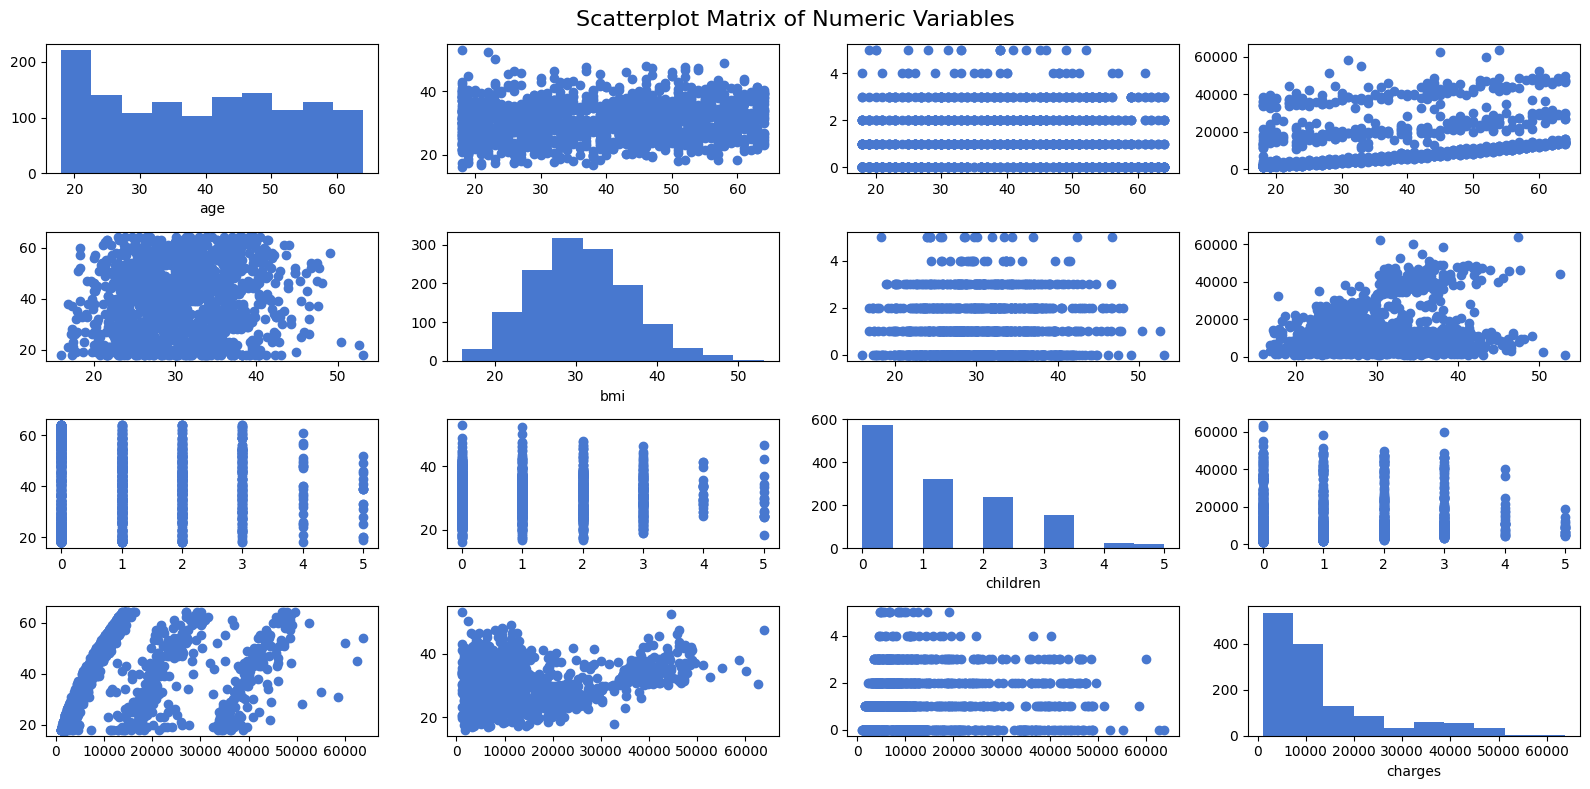

In [55]:
plt.style.use('seaborn-v0_8-muted')

# Numeric Columns
fig_num, ax_num = plt.subplots(4, 4, figsize=(16,8))
fig_num.suptitle('Scatterplot Matrix of Numeric Variables', fontsize=16)

num_cols = ['age', 'bmi', 'children', 'charges']

for i in range(4):
    for j in range (4):
        # if comparing with the same attribute, we will plot a histogram and indicate the x label
        if (i == j):
            ax_num[i,j].hist(df_insurance[num_cols[i]])
            ax_num[i,j].set_xlabel(num_cols[i])
        # else, plot a scatterplot
        else:
            ax_num[i,j].scatter(df_insurance[num_cols[i]], df_insurance[num_cols[j]])

plt.tight_layout()
plt.show()

**Interpretation of Histograms**

It seems that the `charges` data is right-skewed, corroborating the evidence found earlier.

The rest of the histogram seem to point toward a normal or even distribution in the data.

Although the `children` data is right-skewed as well, this variable is not continuous, it is discrete. So there is no need to transform the data into normal.

**Interpretation of Scatterplot**

There seems to be some positive correlation between `charges` and `age`/`bmi`. Suggesting that a higher age/bmi is correlated to higher charges as well.

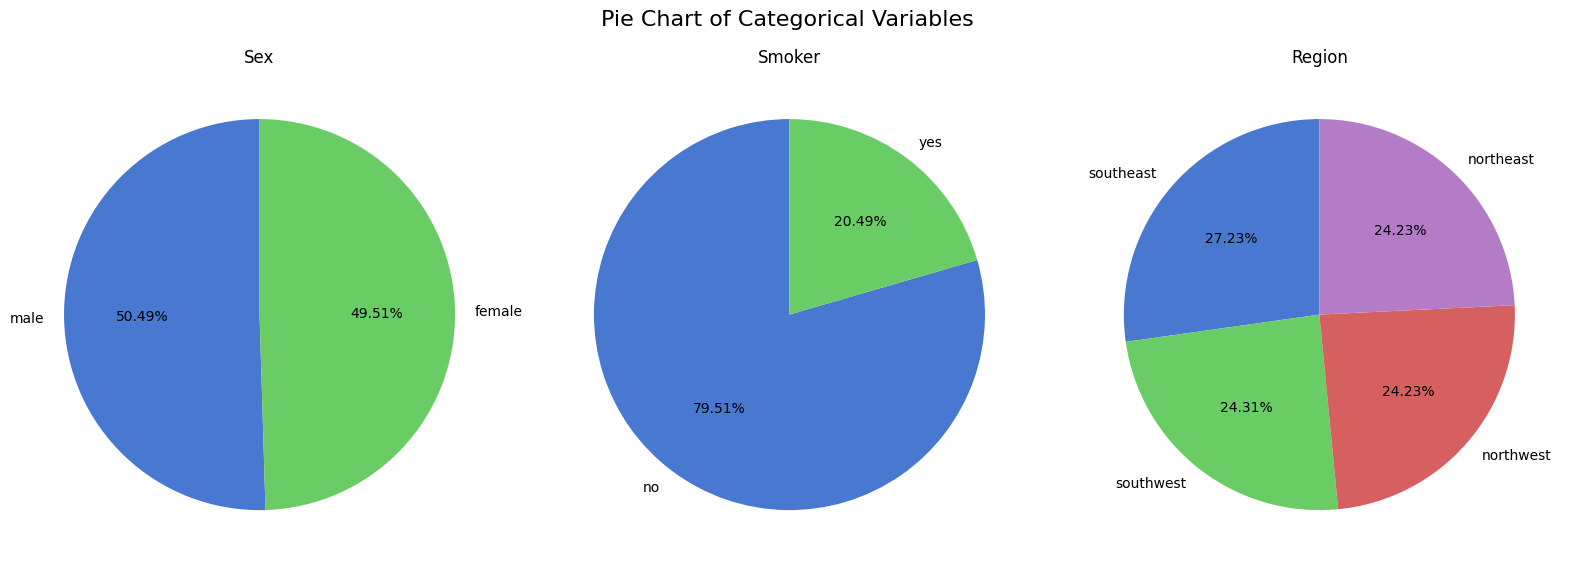

In [56]:
# Categorical Columns
cat_cols = ['sex', 'smoker', 'region']

fig_cat, axes_cat = plt.subplots(1, 3, figsize=(16, 6))
fig_cat.suptitle('Pie Chart of Categorical Variables', fontsize=16)

for i, col in enumerate(cat_cols):
    counts = df_insurance[col].value_counts()
    axes_cat[i].pie(counts, labels=counts.index, autopct='%1.2f%%', startangle=90)
    axes_cat[i].set_title(col.capitalize())

plt.tight_layout()
plt.show()


Based on the pie charts, we see that each `sex` and all `regions` are uniformly represented.

However, `smoker` is not uniformly represented. This imbalance is fine as we are not predicting `smoker`.

Now, we can go ahead to encode these categorical variables.

In [57]:
# keep the original df for other wrangling later on
df_insurance_original = df_insurance.copy()
df_insurance = pd.get_dummies(df_insurance, drop_first=True)
print(df_insurance.columns)

Index(['age', 'bmi', 'children', 'charges', 'sex_male', 'smoker_yes',
       'region_northwest', 'region_southeast', 'region_southwest'],
      dtype='object')


We have chosen to use **one-hot encoding** to transform the categorical variables (`sex`, `smoker`, `region`) into binary indicator columns.

### **3.2 Outlier Detection**

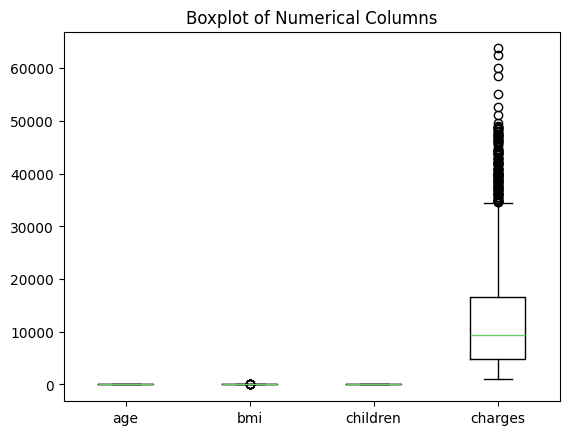

Number of outliers in charges: 139
Proportion of outliers: 10.4%


In [58]:
bplot = plt.boxplot(df_insurance[num_cols].values, tick_labels=num_cols)
plt.title('Boxplot of Numerical Columns')
plt.show()

outlier_charges = bplot['fliers'][3].get_ydata() # index 3 corresponds to charges
num_outliers = len(outlier_charges)
print("Number of outliers in charges:", num_outliers)
prop_outliers = round(num_outliers / len(df_insurance) * 100, 2)
print("Proportion of outliers: ", prop_outliers, "%", sep='')

Visually, we can see that there seems to be some outliers in `bmi` and `charges`.

Specifically, there are 139 outliers in `charges`, which makes up for 10.39% of the total data. This suggests that there are observations of people who are getting charged significantly higher than the rest. This is supported by the histogram above, which shows a right skew. This confirms that there are significant outliers in the dataset which disproportionately increases the mean. **It would not be wise to remove this data as it could contain information about higher insurance premiums, useful for the model prediction.**

We could further investigate extreme outliers in `charges` using the 3 * IQR criterion using z_scores.

In [59]:
df_insurance['z_score'] = zscore(df_insurance['charges'])
extreme_outliers = df_insurance[df_insurance['z_score'].abs() > 3]
df_insurance = df_insurance.drop('z_score', axis =1)

print("Extreme outliers:")
print(extreme_outliers)
print("\n")

num_extreme = len(extreme_outliers)
print("Number of extreme outliers in charges:", num_extreme)
prop_extreme = round(num_extreme / len(df_insurance) * 100, 2)
print("Proportion of extreme outliers: ", prop_extreme, "%", sep='')

Extreme outliers:
      age     bmi  children      charges  sex_male  smoker_yes  \
34     28  36.400         1  51194.55914      True        True   
543    54  47.410         0  63770.42801     False        True   
577    31  38.095         1  58571.07448     False        True   
819    33  35.530         0  55135.40209     False        True   
1146   60  32.800         0  52590.82939      True        True   
1230   52  34.485         3  60021.39897      True        True   
1300   45  30.360         0  62592.87309      True        True   

      region_northwest  region_southeast  region_southwest   z_score  
34               False             False              True  3.131998  
543              False              True             False  4.170826  
577              False             False             False  3.741334  
819               True             False             False  3.457531  
1146             False             False              True  3.247337  
1230              True     

There are significantly fewer extreme outliers (~0.52% of the total data). However, we will still choose to keep these extreme outliers as it still represents important information about extravagent insurance charges.

Instead, we will choose to transform `charges` into `log_charges` by applying a log transformation.

In [60]:
df_insurance['log_charges'] = np.log(df_insurance['charges'])


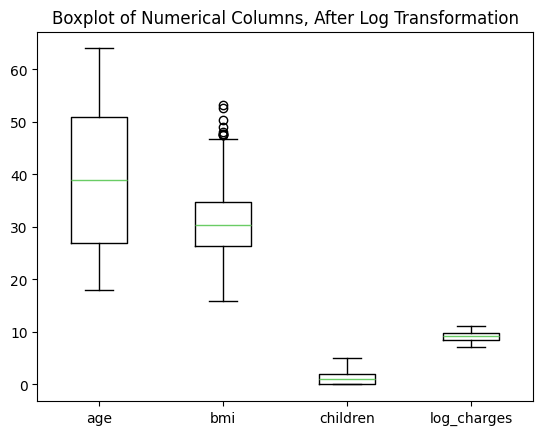

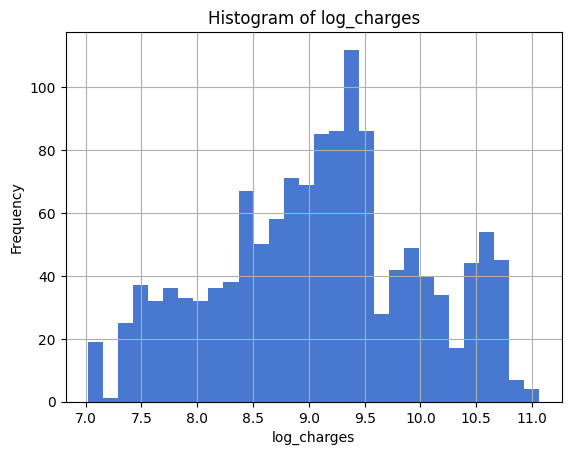

In [61]:
log_num_cols = ['age', 'bmi', 'children', 'log_charges']

bplot = plt.boxplot(df_insurance[log_num_cols].values, tick_labels=log_num_cols)
plt.title('Boxplot of Numerical Columns, After Log Transformation')
plt.show()

df_insurance['log_charges'].hist(bins=30)
plt.title('Histogram of log_charges')
plt.xlabel('log_charges')
plt.ylabel('Frequency')
plt.show()

After the log transformation, the distribution of `log_charges` is appears to be rather normally distributed and there are no more outliers.

### **3.3 Correlation Analysis**

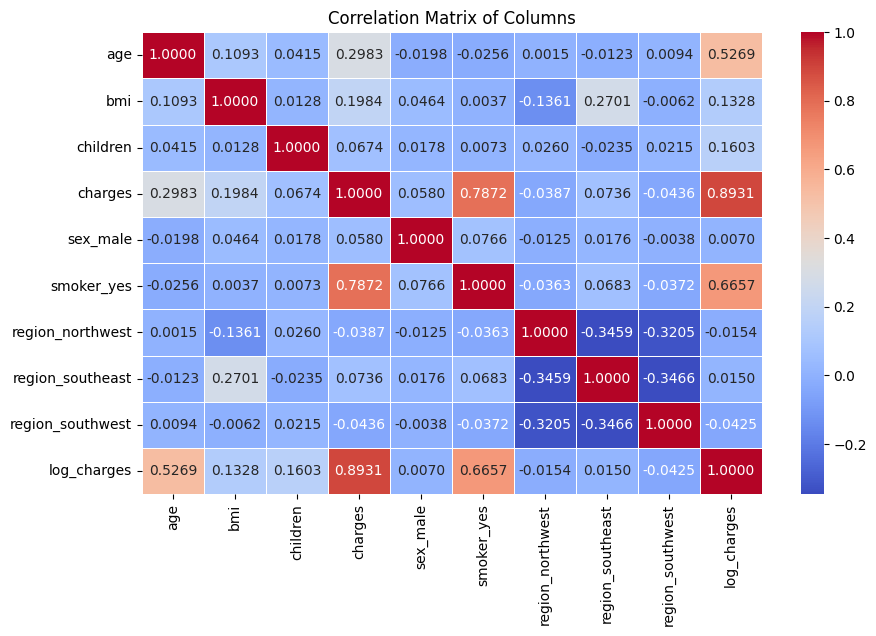

In [62]:
correlation_matrix = df_insurance.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', linewidths=0.5)
plt.title('Correlation Matrix of Columns')
plt.show()

Based on the correlation matrix, these features seem to be highly/moderately positively correlated with `log_charges`
- `age` (0.5269)
- `bmi` (0.1382)
- `children` (0.1603)
- `smoker_yes` (0.6657)

These features do not appear to be highly correlated with one another, suggesting that issues of multicollinearity are unlikely to arise when including them in the model.

It may also be worthwhile to include `sex_male` as a variable to explore whether gender has any influence on insurance charges as it raises potential concerns related to fairness in insurance charges.

Therefore, the features selected for inclusion in the regression models are: `age`, `bmi`, `children`, `smoker_yes`, and `sex_male`.

## **4. Building the Models**

In [63]:
y = df_insurance['log_charges']
X = df_insurance[['age', 'bmi', 'children', 'sex_male', 'smoker_yes']]
features = X.columns

random_state = 44 # for reproducability

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state=random_state)

## **4.1 Linear Regression**

In [64]:
lr = LinearRegression()
lr.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [65]:
y_pred = lr.predict(X_test)

r2_lr = r2_score(y_test, y_pred)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred))
mae_lr = mean_absolute_error(y_test, y_pred)

print(f"Linear Regression Summary")
print("-" * 45)
print(f"Coefficients: {lr.coef_}")
print(f"Intercept: {lr.intercept_}\n\n")

print("Model Performance (Linear Regression)")
print("-" * 45)
print(f"R-squared: {r2_lr:.4f}")
print(f"RMSE: {rmse_lr:.4f}")
print(f"MAE: {mae_lr:.4f}")

Linear Regression Summary
---------------------------------------------
Coefficients: [ 0.0343265   0.01071341  0.10633332 -0.07365019  1.56655154]
Intercept: 7.038476700205566


Model Performance (Linear Regression)
---------------------------------------------
R-squared: 0.8028
RMSE: 0.4004
MAE: 0.2569


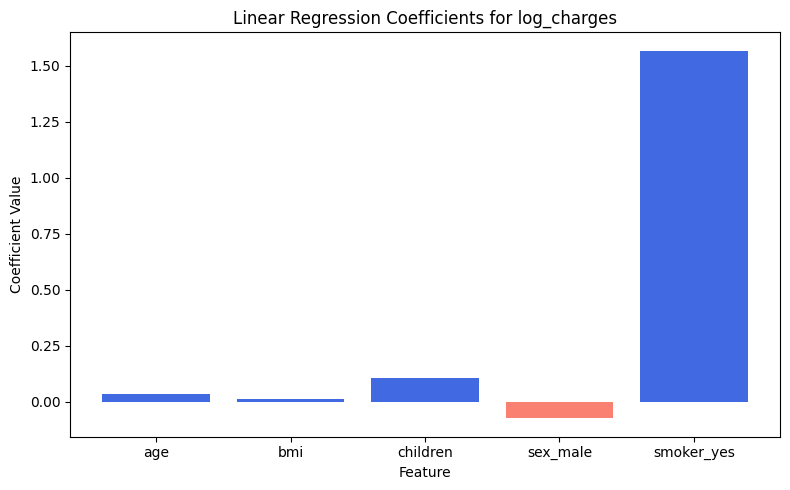

In [66]:
coefficients = lr.coef_

plt.figure(figsize=(8, 5))
bars = plt.bar(features, coefficients, color=np.where(coefficients >= 0, 'royalblue', 'salmon'))
plt.title("Linear Regression Coefficients for log_charges")
plt.xlabel("Feature")
plt.ylabel("Coefficient Value")
plt.tight_layout()
plt.show()

From the bar plot, we can observe that `smoker_yes` has the strongest effect on `log_charges` in the Linear Regression Model. This suggests that smoking status is the most influential factor affecting insurance charges.

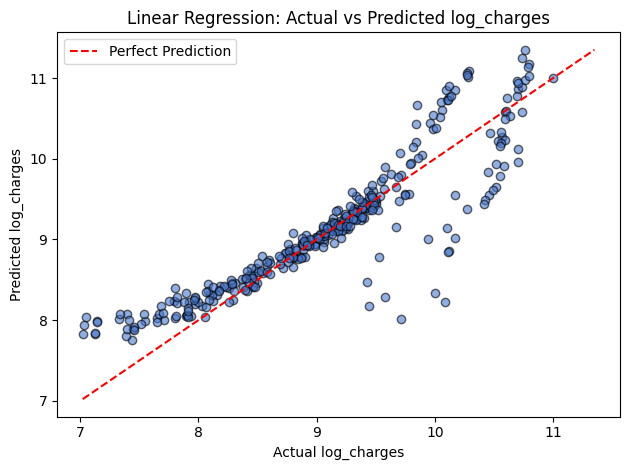

In [67]:
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
lims = [
    np.min([y_test.min(), y_pred.min()]),
    np.max([y_test.max(), y_pred.max()])
]
plt.plot(lims, lims, 'r--', label='Perfect Prediction')
plt.title("Linear Regression: Actual vs Predicted log_charges")
plt.xlabel("Actual log_charges")
plt.ylabel("Predicted log_charges")
plt.legend()
plt.tight_layout()
plt.show()

## **4.2 RandomForest**

In [68]:
rf = RandomForestRegressor(
    n_estimators = 300,
    max_depth = 5,
    random_state = random_state
)

rf.fit(X_train, y_train)

,n_estimators,300
,criterion,'squared_error'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [69]:
y_pred = rf.predict(X_test)

r2_rf = r2_score(y_test, y_pred)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))
mae_rf = mean_absolute_error(y_test, y_pred)

print("Model Performance (Random Forest)")
print("-" * 45)
print(f"R-squared: {r2_rf:.4f}")
print(f"RMSE: {rmse_rf:.4f}")
print(f"MAE: {mae_rf:.4f}")

Model Performance (Random Forest)
---------------------------------------------
R-squared: 0.8792
RMSE: 0.3134
MAE: 0.1802


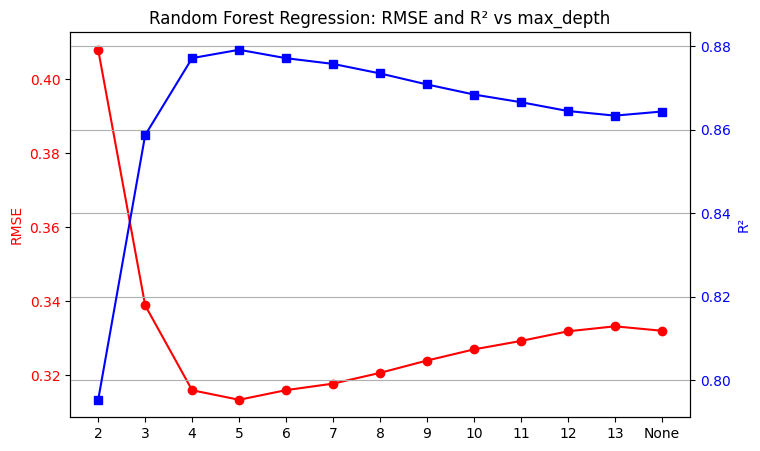

In [70]:
depth_values = list(range(2, 15))
rmse_values, r2_values = [], []

#iterate through increasing depth
for depth in depth_values:
  rf_iter = RandomForestRegressor(
      n_estimators= 300,
      max_depth = depth,
      random_state = random_state
  )
  rf_iter.fit(X_train, y_train)
  y_pred = rf_iter.predict(X_test)

  #calculate statistics
  rmse_values.append(np.sqrt(mean_squared_error(y_test, y_pred)))
  r2_values.append(r2_score(y_test, y_pred))

labels = [str(d) for d in depth_values[:-1]] + ["None"]

# Plot both metrics
fig, ax1 = plt.subplots(figsize=(8,5))

ax1.plot(labels, rmse_values, marker='o', color='red', label='RMSE')
ax1.set_ylabel('RMSE', color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()
ax2.plot(labels, r2_values, marker='s', color='blue', label='R²')
ax2.set_ylabel('R²', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('Random Forest Regression: RMSE and R² vs max_depth')
plt.xlabel('max_depth (None = fully grown trees)')
plt.grid(True)
plt.show()


From this diagram, we can tell that the depth we should choose is depth = 5. At this value, the R-squared is the highest, while RMSE is the lowest. The model achieve the best balance between bias and variance at this depth. It captures the underlying patterns in the data without overfitting, resulting in strong predictive performance and good generalisation to unseen data.

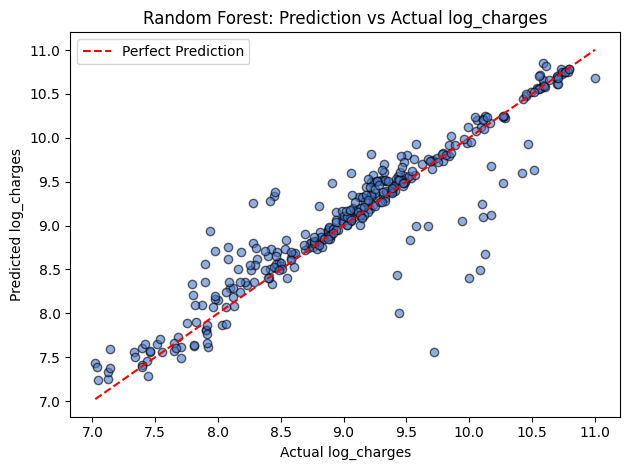

In [71]:
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
lims = [
    np.min([y_test.min(), y_pred.min()]),
    np.max([y_test.max(), y_pred.max()])
]
plt.plot(lims, lims, 'r--', label='Perfect Prediction')
plt.xlabel('Actual log_charges')
plt.ylabel('Predicted log_charges')
plt.title('Random Forest: Prediction vs Actual log_charges')
plt.legend()
plt.tight_layout()
plt.show()

## **4.3 XGBoost**

### **4.3.1 Initial Performance of Model**

In [72]:
xgb_reg = xgb.XGBRegressor(random_state=random_state)
xgb_reg.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [73]:
y_pred = xgb_reg.predict(X_test)

r2_xgb = r2_score(y_test, y_pred)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred))
mae_xgb = mean_absolute_error(y_test, y_pred)

print("Model Performance (XGBoost)")
print("-" * 45)
print(f"R-squared: {r2_xgb:.4f}")
print(f"RMSE: {rmse_xgb:.4f}")
print(f"MAE: {mae_xgb:.4f}")

Model Performance (XGBoost)
---------------------------------------------
R-squared: 0.8382
RMSE: 0.3627
MAE: 0.2116


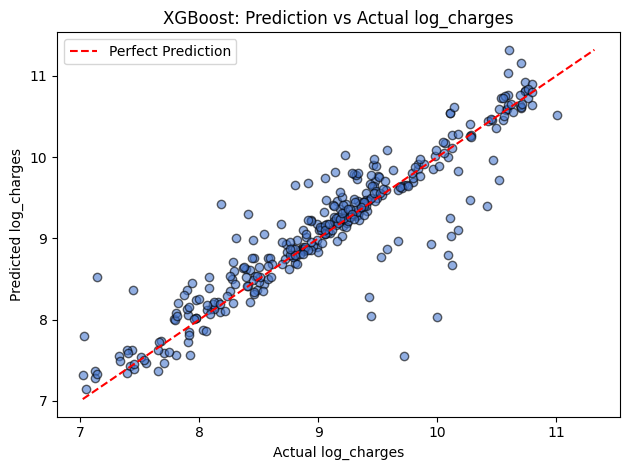

In [74]:
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
lims = [
    np.min([y_test.min(), y_pred.min()]),
    np.max([y_test.max(), y_pred.max()])
]
plt.plot(lims, lims, 'r--', label='Perfect Prediction')
plt.xlabel('Actual log_charges')
plt.ylabel('Predicted log_charges')
plt.title('XGBoost: Prediction vs Actual log_charges')
plt.legend()
plt.tight_layout()
plt.show()

### **4.3.2 Hyperparameter Tuning**

In [75]:
# param_dist = {
#     "max_depth": randint(3, 10),
#     "learning_rate": uniform(0.01, 0.09),
#     "subsample": uniform(0.5, 0.5),
#     "colsample_bytree": uniform(0.6, 0.4),
#     "min_child_weight": randint(1, 7),
#     "n_estimators": randint(100, 800),
# }

# xgb_model = xgb.XGBRegressor(
#     objective="reg:squarederror",
#     n_jobs=-1,
#     random_state=random_state
# )

# random_search_xgb = RandomizedSearchCV(
#     estimator=xgb_model,
#     param_distributions=param_dist,
#     n_iter=300,
#     cv=5,
#     scoring="neg_root_mean_squared_error", # minimise RMSE
#     n_jobs=-1,
#     verbose=1,
#     random_state=random_state
# )

# random_search_xgb.fit(X_train, y_train)

### **4.3.3 Performance After Hyperparameter Tuning**

In [76]:
if 'random_search_xgb' not in locals():
    print("random_search_xgb is not defined, importing model using joblib")
    best_xgb = joblib.load("best_xgb_model.pkl")
else:
    print("random_search_xgb exist, using best_estimator_")
    best_xgb = random_search_xgb.best_estimator_

random_search_xgb is not defined, importing model using joblib


In [77]:
y_pred = best_xgb.predict(X_test)

r2_train_best_xgb = best_xgb.score(X_train, y_train)
r2_test_best_xgb = best_xgb.score(X_test, y_test)
rmse_best_xgb = np.sqrt(mean_squared_error(y_test, y_pred))
mae_best_xgb = mean_absolute_error(y_test, y_pred)

print("XGBoost: Model Performance (After Hyperparameter Tuning)")
print("-" * 45)
print(f"R-squared (Train): {r2_train_best_xgb:.4f}")
print(f"R-squared (Test): {r2_test_best_xgb:.4f}")
print(f"RMSE: {rmse_best_xgb:.4f}")
print(f"MAE: {mae_best_xgb:.4f}")

XGBoost: Model Performance (After Hyperparameter Tuning)
---------------------------------------------
R-squared (Train): 0.8347
R-squared (Test): 0.8822
RMSE: 0.3095
MAE: 0.1778


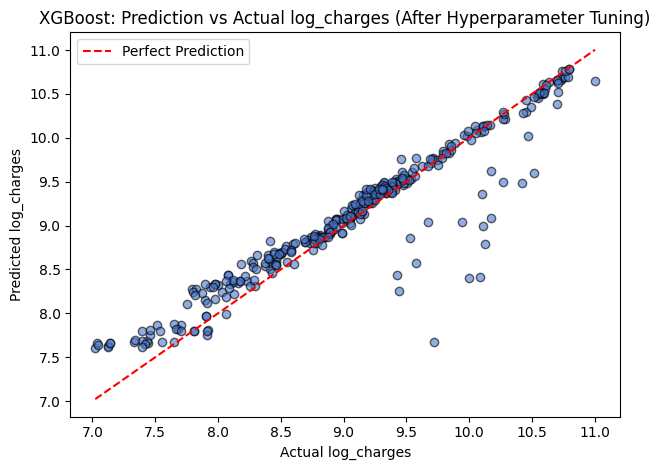

In [78]:
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
lims = [
    np.min([y_test.min(), y_pred.min()]),
    np.max([y_test.max(), y_pred.max()])
]
plt.plot(lims, lims, 'r--', label='Perfect Prediction')
plt.xlabel('Actual log_charges')
plt.ylabel('Predicted log_charges')
plt.title('XGBoost: Prediction vs Actual log_charges (After Hyperparameter Tuning)')
plt.legend()
plt.tight_layout()
plt.show()

After tuning the hyperparameters, we can see that more of the data points lie closer to the red line, indicating that the predictions are more accurate:
- R-squared (Test) has increased from 0.8382 to **0.8822**. It is also higher than the R-squared (Train), indicating that the model is **not overfit** and could indicate that it is actually well fit.
- RMSE has decreased from 0.3627 to **0.3095**.
- MAE has decreased from 0.2116 to **0.1778**.

### **4.4 Overall Best Model**

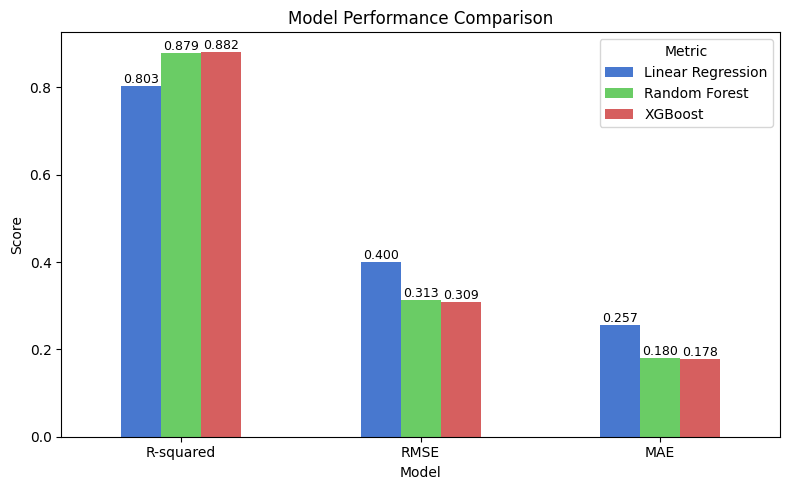

In [79]:
overall_results = {
    "Best Model": ["Linear Regression", "Random Forest", "XGBoost"],
    "R-squared": [r2_lr, r2_rf, r2_test_best_xgb],
    "RMSE": [rmse_lr, rmse_rf, rmse_best_xgb],
    "MAE": [mae_lr, mae_rf, mae_best_xgb],
}

df_results = pd.DataFrame(overall_results).set_index("Best Model").T

ax = df_results.plot(kind="bar", figsize=(8, 5), rot=0)

# add labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', label_type='edge', fontsize=9)

plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xlabel("Model")
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

Since **XGBoost** had performed the best in these metrics, we decided to convert the predicted and test values for XGBoost back to the actual values for greater interpretability of the metrics:

In [80]:
y_pred_original = np.exp(y_pred)
y_test_original = np.exp(y_test)

r2_real = r2_score(y_test_original, y_pred_original)
rmse_real = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mae_real = mean_absolute_error(y_test_original, y_pred_original)

print("XGBoost: Model Performance (Converting Back to Actual Values)")
print("-" * 45)
print(f"R-squared (Test): {r2_real:.4f}")
print(f"RMSE: {rmse_real:.4f}")
print(f"MAE: {mae_real:.4f}")

XGBoost: Model Performance (Converting Back to Actual Values)
---------------------------------------------
R-squared (Test): 0.8956
RMSE: 3836.6925
MAE: 1773.7704


The new metrics are as follows:
- R-squared: 0.8956. This indicates that approximately 89.56% of the variance in insurance charges can be explained by the model's features.
- MAE: 1773.77. This means that, on average, the model’s predicted insurance charges deviate from the true values by about \$1,774.
- RMSE: 3836.69. This is the square root of the average of squared prediction errors. Squaring penalises large errors more than small ones. While most predictions are close to the true value \(around \$1,774 off\), some predictions are much further off, and RMSE captures these larger errors, giving a sense of worst-case impact.

### **4.4.1 Feature Importance**

To investigate feature importance, we have only decided to use **Random Forest and XGBoost** because Linear Regression does not inherently capture feature importance in the same way tree-based models do. Even though Linear Regression models have coefficients, these values do not directly reflect feature importance in the same way as tree-based models.

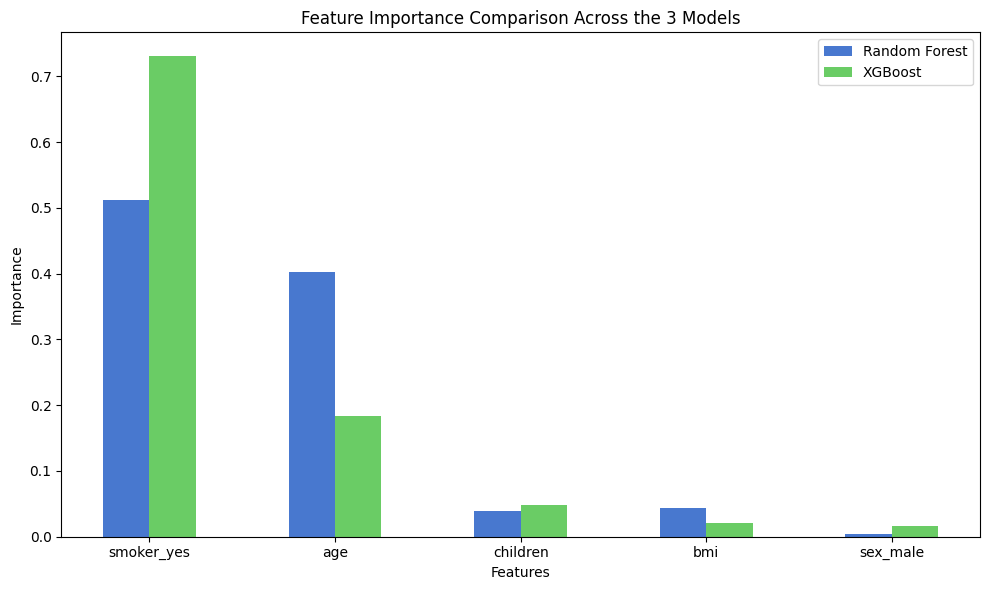

In [81]:
fi_rf = pd.Series(rf.feature_importances_)
fi_xgb = pd.Series(best_xgb.feature_importances_)

df_fi = pd.DataFrame({
    "Feature": features,
    "Random Forest": fi_rf,
    "XGBoost": fi_xgb
})

# sort by one of the models for easier visualisation
df_fi = df_fi.sort_values(by="XGBoost", ascending=False).reset_index(drop=True)
x = np.arange(len(df_fi))

fig, ax = plt.subplots(figsize=(10, 6))

width = 0.25
ax.bar(x - width/2, df_fi["Random Forest"], width, label='Random Forest')
ax.bar(x + width/2, df_fi["XGBoost"], width, label='XGBoost')

ax.set_xlabel("Features")
ax.set_ylabel("Importance")
ax.set_title("Feature Importance Comparison Across the 3 Models")
ax.set_xticks(x)
ax.set_xticklabels(df_fi["Feature"])
ax.legend()
plt.tight_layout()
plt.show()

Both the Random Forest and XGBoost models indicate that `smoker_yes` and `age` are clearly important features for predicting insurance charges. Additionally, `children` and to a lesser extent, `bmi` appear to contribute meaningfully to the predictions as well.

sex_male` does not seem important in predicting insurance charges. This means that an individual’s gender does not significantly influence the model’s predictions, suggesting that the model does not rely on gender when estimating insurance costs. This is a good thing, indicating fairness in the distribution of insurance charges.


### **4.4.2 Top 10 Wrongly Predicted Data Points**

In [82]:
y_pred_original = np.exp(y_pred)
y_test_original = np.exp(y_test)

abs_err = np.abs(y_pred_original - y_test_original)

err_df = pd.DataFrame({
    "charges": y_test_original,
    "predicted_charges": y_pred_original,
    "abs_error": abs_err
}, index=X_test.index)

top10_worst = err_df.sort_values("abs_error", ascending=False).head(10)
top10_worst_with_features = pd.concat(
    [X_test.loc[top10_worst.index], top10_worst],
    axis=1
)

top10_worst_with_features

,age,bmi,children,sex_male,smoker_yes,charges,predicted_charges,abs_error
1206,59,34.800,2,False,False,36910.60803,14702.106445,22208.501585
599,52,37.525,2,False,False,33471.97189,13119.055664,20352.916226
526,19,30.590,2,False,False,24059.68019,4519.104004,19540.576186
637,35,38.095,2,False,False,24915.04626,6581.731934,18333.314326
1230,52,34.485,3,True,True,60021.39897,41965.246094,18056.152876
3,33,22.705,0,True,False,21984.47061,4433.898926,17550.571684
688,47,24.100,1,False,False,26236.57997,8788.711914,17447.868056
355,46,27.600,0,True,False,24603.04837,8029.290039,16573.758331
9,60,25.840,0,False,False,28923.13692,13323.617188,15599.519733
397,21,31.020,0,True,False,16586.49771,2141.795410,14444.702300


We have extracted the cases with the largest prediction errors. A common pattern among these high-error cases is related to the `smoker_yes` feature, which is an important predictor of insurance charges. From the positive coefficient in the linear regression model, we know that smokers tend to have higher charges. However, in these particular cases, the individuals do not smoke but still have high charges. As a result, the model underestimates their insurance costs, leading to large errors.

Perhaps the dataset fails to capture pre-existing health conditions \(that BMI does not capture\)that may contribute to the individuals' high insurance charges.

## **5. Fairness Checks**

### **5.1 Visualisation Check**

We are focusing our fairness analysis on `sex` and `region`. This is because it is reasonable for insurance charges to depend on health-related features such as age or BMI, which directly affect risk. However, it is considered unfair to set charges based on an individual’s gender or place of residence, as these characteristics are unrelated to personal health risk.

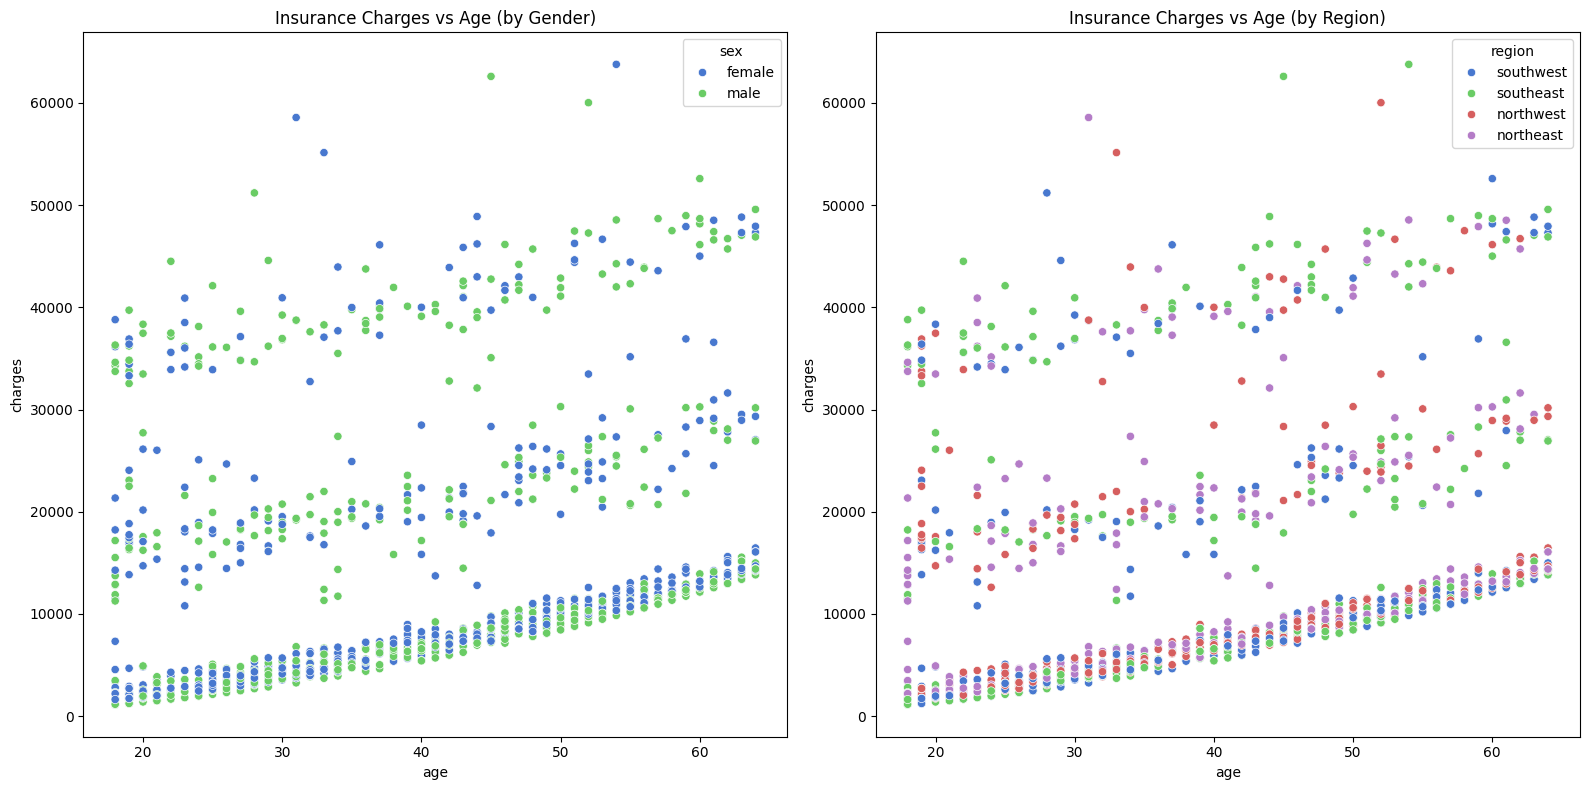

In [83]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.scatterplot(data=df_insurance_original, x='age', y='charges', hue='sex', ax=ax[0])
ax[0].set_title('Insurance Charges vs Age (by Gender)')

sns.scatterplot(data=df_insurance_original, x='age', y='charges', hue='region', ax=ax[1])
ax[1].set_title('Insurance Charges vs Age (by Region)')

plt.tight_layout()
plt.show()

Based on the scatterplots, the distribution of insurance charges across genders and regions appears fairly random, with no clear pattern indicating that a particular gender or region consistently incurs higher or lower charges. Therefore, we cannot conclude that insurance costs differ systematically by gender or region from these plots alone.

### **5.2 ANOVA**

To determine whether there are statistically significant differences in insurance charges across different groups, we will run an Analysis of Variance (ANOVA). Specifically, we will compare the mean charges between `sex` (male and female) and `region` (southwest, southeast, northwest, northeast) to see if any subgroup has significantly higher or lower insurance costs.

We will use a 5% level of significance for the following tests.

#### **5.2.1 ANOVA for `sex`**

\begin{align*}
H_0 &: \mu_\text{male} = \mu_\text{female} \\
H_1 &: \mu_\text{male} \neq \mu_\text{female}
\end{align*}

In [84]:
model_gender = ols('charges ~ C(sex)', data=df_insurance_original).fit()
anova_gender = sm.stats.anova_lm(model_gender, typ=2)
print("ANOVA results for sex:")
print(anova_gender)

ANOVA results for sex:
                sum_sq      df         F    PR(>F)
C(sex)    6.601500e+08     1.0  4.513038  0.033821
Residual  1.952787e+11  1335.0       NaN       NaN


Based on the p-value of 0.0338 (F-statistics of 4.51), which is lesser than 0.05, we are able to reject the null hypothesis that the mean insurance charges are the same for males and females at the 5% level of significance and conclude that the **mean insurance charges are different for at least one gender**.

Although ANOVA does not specify which group has higher charges, we can refer to the linear regression results, where the coefficient for `sex_male` is negative (with False = female). This suggests that, on average, males tend to have slightly lower predicted charges than females in this dataset.

#### **5.2.1 ANOVA for `region`**

\begin{align*}
H_0 &: \mu_\text{southwest} = \mu_\text{southeast} = \mu_\text{northwest} = \mu_\text{northeast} \\
H_1 &: \text{At least one regional mean differs from the others}
\end{align*}

In [85]:
model_region = ols('charges ~ C(region)', data=df_insurance_original).fit()
anova_region = sm.stats.anova_lm(model_region, typ=2)
print("ANOVA results for region:")
print(anova_region)

ANOVA results for region:
                 sum_sq      df        F    PR(>F)
C(region)  1.281906e+09     3.0  2.92614  0.032763
Residual   1.946569e+11  1333.0      NaN       NaN


Based on the p-value of 0.0328 (F-statistics of 2.93), which is lesser than 0.05, we are able to reject the null hypothesis that the mean insurance charges are the same for all the regions at the 5% level of significance and conclude that the **mean insurance charges are different for at least region**.

### **5.3 Conclusion on Fairness**

Based on the analysis above, there appear to be fairness concerns, as females are being charged statistically higher than males, and insurance charges also differ across regions.